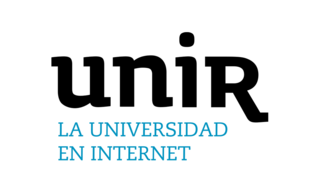

_Máster Universitario en Inteligencia Artificial_

_Trabajo Fin de Máster_

- Gustavo Mateos Santos
- gustavo.mateos830@comunidadunir.net

# Clasificación automática de estrellas variables con modelos Transformer aplicados a series temporales



## **Fase 2: DATA AUGMENTATION**

Tras los anteriores ciclos de entrenamiento y doble fine tuning, con incorporación de features estadísticas en los datos, aquí realizamos una nueva fase completa aplicando también ***Data Augmentation***.

El objetivo es simular nuevas curvas a partir de las existentes sin alterar su clase, mejorando la robustez del modelo a ruido, desplazamientos o huecos.



## NUEVO CICLO DE ENTRENAMIENTO Y FINE TUNING CON *DATA AUGMENTATION*

Técnicas recomendadas (seguras para series temporales astronómicas). Todas operan sobre secuencias 1D y son compatibles con seq_length=25000:

| Técnica                | Descripción                                                               | Impacto esperado |
| ---------------------- | ------------------------------------------------------------------------- | ---------------- |
| **Jittering**          | Añadir ruido Gaussiano leve                                               | Aumenta robustez |
| **Scaling**            | Multiplicar la curva por un factor aleatorio cercano a 1                  | Invarianza       |
| **Magnitude Warping**  | Perturbar la amplitud de forma no lineal (más caro)                       | Variabilidad     |
| **Permutation (leve)** | Reordenar segmentos cortos                                                | Tolerancia local |
| **Time Masking**       | Anular aleatoriamente tramos de la curva (ya haces algo similar con mask) | Generaliza ruido |

Parámetros:

| Parámetro          | Justificación técnica                                                                 |
| ------------------ | ------------------------------------------------------------------------------------- |
| `p=0.4`            | Evita sobrecargar con augmentations múltiples simultáneas (40% probabilidad por modo) |
| `sigma=0.01`       | Ruido leve que simula variabilidad instrumental sin distorsionar la señal astronómica |
| `jitter_shift=100` | Simula errores de alineamiento temporal leves, sin romper la secuencia global         |
| `mask_len=500`     | Simula gaps típicos de observación (ocultación, nubes, errores de telemetría...)      |

Para curvas de luz astronómicas ya normalizadas y con longitud fija (`seq_length = 25000`), los *augmentations* deben ser cuidadosos para no alterar la naturaleza física de la variabilidad estelar ni introducir ruido artificial irrelevante.

Otras transformaciones adicionales recomendables a añadir a la función `apply_augmentation()`:

**Scaling** (escalado por factor aleatorio):

Multiplica la curva por un pequeño factor aleatorio. Simula pequeñas diferencias de calibración o amplitud intrínseca.

```python
elif mode == "scaling":
    scale = torch.empty(x_aug.size(0), 1, device=x_aug.device).uniform_(0.9, 1.1)
    x_aug *= scale
```

**Magnitude offset** (desplazamiento vertical):

Añade un pequeño offset constante a toda la curva. Simula errores de calibración del instrumento.

```python
elif mode == "offset":
    offset = torch.empty(x_aug.size(0), 1, device=x_aug.device).uniform_(-0.05, 0.05)
    x_aug += offset
```

**Window dropout** (borrado aleatorio de varias ventanas pequeñas):

Más robusto que el masking único. Simula pérdida de datos real.

```python
elif mode == "window_dropout":
    for i in range(x_aug.size(0)):
        n_windows = 5
        for _ in range(n_windows):
            start = torch.randint(0, x_aug.size(1) - 50, (1,)).item()
            x_aug[i, start:start + 50] = 0.0
```

Para el siguiente ciclo de entrenamiento, activamos inicialmente esta combinación:

```python
modes=["gaussian", "jitter", "masking", "scaling", "offset", "window_dropout"]
```

### 1. TRAINING

🔄 Restaurando datasets...
✅ Dataset cargado en 20.74 segundos
🔄 Cargando datasets completos...
Total batches in train_loader: 202
Total batches in val_loader: 58
✅ Comprobación completada
TOTAL CLASES: 7
🚀 Entrenando modelo optimizado...
🔍 Pesos de clase (antes del clip): [3.80092229 1.05936885 0.87843537 0.87843537 0.87843537 0.87843537
 0.80684398]
Modelo en: cuda:0


Entrenamiento del modelo:   0%|          | 0/50 [00:00<?, ?it/s]

[TRAIN] TIEMPO ÉPOCA: 143.1756s
[VAL] TIEMPO ÉPOCA: 41.5654s

🧪 Epoch 1/50
Train loss: 1.9096, Val loss: 1.8068
Train acc: 0.2318, Val acc: 0.3647
💾 Guardado modelo mejorado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado.pt
[TRAIN] TIEMPO ÉPOCA: 140.3830s
[VAL] TIEMPO ÉPOCA: 40.6598s

🧪 Epoch 2/50
Train loss: 1.7914, Val loss: 1.7109
Train acc: 0.3379, Val acc: 0.4241
💾 Guardado modelo mejorado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado.pt
[TRAIN] TIEMPO ÉPOCA: 140.6867s
[VAL] TIEMPO ÉPOCA: 40.7830s

🧪 Epoch 3/50
Train loss: 1.7160, Val loss: 1.6398
Train acc: 0.3850, Val acc: 0.4523
💾 Guardado modelo mejorado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado.pt
[TRAIN] TIEMPO ÉPOCA: 140.5308s
[VAL] TIEMPO ÉPOCA: 40.6633s

🧪 Epoch 4/50
Train loss: 1.6589, Val loss: 1.5843
Train acc: 0.4105, Val acc: 0.4717
💾 Guardado modelo mejorado en /home/ec2-

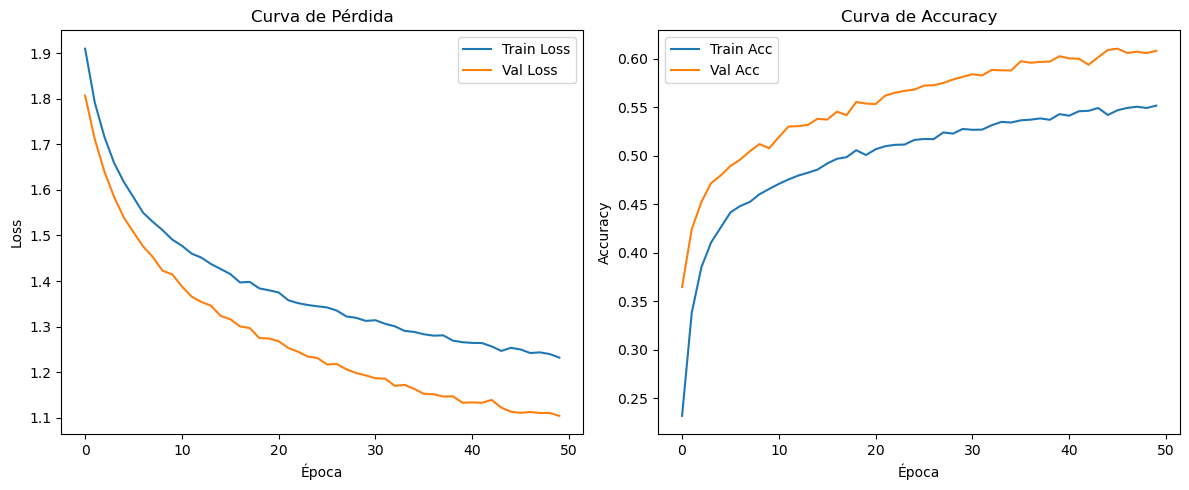


📊 Classification Report:
{'0': {'precision': 0.25877192982456143, 'recall': 0.5673076923076923, 'f1-score': 0.35542168674698793, 'support': 416.0}, '1': {'precision': 0.6323185011709602, 'recall': 0.5428954423592494, 'f1-score': 0.5842048323115759, 'support': 1492.0}, '2': {'precision': 0.6297850026219193, 'recall': 0.6672222222222223, 'f1-score': 0.6479633126517399, 'support': 1800.0}, '3': {'precision': 0.6925391095066186, 'recall': 0.6394444444444445, 'f1-score': 0.6649335644136337, 'support': 1800.0}, '4': {'precision': 0.7525225703664365, 'recall': 0.7872222222222223, 'f1-score': 0.7694814010317675, 'support': 1800.0}, '5': {'precision': 0.5872679045092838, 'recall': 0.615, 'f1-score': 0.6008141112618725, 'support': 1800.0}, '6': {'precision': 0.5260078023407022, 'recall': 0.41275510204081634, 'f1-score': 0.46255002858776445, 'support': 1960.0}, 'accuracy': 0.6081496205276473, 'macro avg': {'precision': 0.5827446886200688, 'recall': 0.6045495893709496, 'f1-score': 0.5836241338579

In [1]:
import sys
import torch
import pickle
from torch.utils.data import DataLoader
from pathlib import Path
import time
import os
import gc

# Liberar memoria antes de cargar los datasets
gc.collect()
torch.cuda.empty_cache()

# Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_training_optimizado2 import main as train_model_optimized2

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

print("🔄 Restaurando datasets...")
start = time.time()
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")
print(f"✅ Dataset cargado en {time.time() - start:.2f} segundos")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=192, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=192, shuffle=False, num_workers=12, pin_memory=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

######################################################################
# Crear un mini-dataloader con batch pequeño para inspección
batch_size = 256
debug_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
for i, (x, y, mask, features) in enumerate(debug_loader):
    if i >= 100:
        break
    # Validaciones de tipo
    if not torch.is_tensor(x) or not torch.is_tensor(mask):
        print(f"❌ No tensor en entrada en batch {i}")
    if not torch.is_tensor(y) or not torch.is_tensor(features):
        print(f"❌ y o features no son tensores en batch {i}")
    # Validaciones de contenido
    if not torch.isfinite(x).all():
        print(f"⚠️ x contiene NaN o Inf en batch {i}")
    if not torch.isfinite(mask).all():
        print(f"⚠️ mask contiene NaN o Inf en batch {i}")
    if not torch.isfinite(features).all():
        print(f"⚠️ features contiene NaN o Inf en batch {i}:\n{features}")
    # Validación de forma
    if features.shape[1] != 7:
        print(f"❌ Tamaño inesperado en features en batch {i}: {features.shape}")
    if x.shape != mask.shape:
        print(f"❌ Tamaños incompatibles en batch {i}: x {x.shape}, mask {mask.shape}")
    # Validación de etiquetas
    for j, label in enumerate(y):
        if not isinstance(label.item(), int):
            print(f"❌ Etiqueta no entera en batch {i}, elemento {j}: {label}")
        if label.item() < 0 or label.item() >= 9:
            print(f"❌ Etiqueta fuera de rango en batch {i}, elemento {j}: {label.item()}")
print("✅ Comprobación completada")
######################################################################

# Calcular número de clases
label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"TOTAL CLASES: {num_classes}")

# Ejecutar entrenamiento optimizado: 
# Ponderación por clase con class_weight
# dropout=0.3
# Scheduler ReduceLROnPlateau
# Early stopping
# Curvas de pérdida y accuracy
print("🚀 Entrenando modelo optimizado...")
model = train_model_optimized2(
    train_loader=train_loader,
    val_loader=val_loader,
    label_encoder=label_encoder,
    device=device,
    epochs=50,
    lr=3e-5,
    freeze_encoder=True,  # transfer learning clásico
    patience=6,           # early stopping
    debug=False           # True para depuración
)

### 2. FINE TUNING 1/2

¿Aplicamos *data augmentation* en fine-tuning?

| Ciclo                                                   | ¿Aplica Data Augmentation? | Justificación                                                                                                                        |
| ------------------------------------------------------- | -------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| 🔧 **Entrenamiento inicial** (`train_model_optimized2`) | ✅ **Sí**                   | Queremos forzar al modelo a aprender representaciones robustas, regularizar y evitar overfitting.                                    |
| 🧪 **Fine-tuning 1** (adaptación al dataset real)       | ⚠️ **Depende**             | Si se entrena sobre datos ya realistas y bien distribuidos, **no suele ser necesario**. Se busca refinar.                            |
| 🧬 **Fine-tuning 2** (ajuste fino con LR bajo)          | 🚫 **No recomendado**      | Aquí el objetivo es estabilizar y mejorar precisión final. El augmentation introduciría ruido y **podría empeorar** la convergencia. |

Dado que:

* Ya estamos aplicando *augmentation* en el entrenamiento base previo.
* El modelo resultante será fine-tuned sobre **datos reales y limpios**.
* Queremos medir claramente si el modelo generaliza bien después del refuerzo.

➡️ No aplicamos *data augmentation* durante los ciclos de fine-tuning.


In [ ]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import torch, gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_fine_tuning_optimizado import main as fine_tuned_optimized_model

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

print("🔄 Restaurando datasets...")
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=12, pin_memory=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Fine-tuning optimizado
# Carga desde mejor_modelo_optimizado.pt
# Doble learning rate (encoder / head)
# Descongelado tras las primeras n epocas (freeze_epochs=n) o desde el principio (con freeze_encoder=False)
# label_smoothing=0.1 para mejorar la generalización (lo hemos quitado en esta prueba)
# Optimización por AdamW con weight_decay.
print("🚀 Fine-tuning sobre mejor modelo optimizado...")
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    label_encoder=label_encoder,
    device=device,
    epochs=40,
    patience=5,
    # freeze_encoder=False,
    freeze_epochs=2,
    encoder_lr=3e-6,
    head_lr=1e-4,   # Para acelerar la adaptación de la capa final
    gamma=3         # No aplica, ya que no usamos label_smoothing
)

3. FINE TUNING 2/2

In [ ]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import torch, gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_fine_tuning_optimizado import main as fine_tuned_optimized_model

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

print("🔄 Restaurando datasets...")
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=12, pin_memory=True,persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False, num_workers=12, pin_memory=True,persistent_workers=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Fine-tuning adicional
# Carga desde mejor_modelo_finetuned_optimizado2.pt
# Encoder descongelado desde el principio (freeze_encoder=False)
print("🚀 Fine-tuning sobre mejor modelo optimizado...")
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="mejor_modelo_finetuned_optimizado2.pt",
    label_encoder=label_encoder,
    device=device,
    epochs=15,
    patience=5,
    freeze_encoder=False,
    encoder_lr=2e-6,
    head_lr=5e-6,
    gamma=3,             # No aplica, ya que no usamos label_smoothing
    use_scheduler=True,  # Usar scheduler ReduceLROnPlateau
)